In [58]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, date_format
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import requests, datetime

spark = SparkSession.builder.appName("WeatherPlot").getOrCreate()


Download dataset

In [4]:
url = "https://raw.githubusercontent.com/Xiru1024/BigDataExercise/refs/heads/main/exampleData.csv"
local_path = "/home/jovyan/BigDataExercise/report1/weather.csv"
with open(local_path, "wb") as f:
    f.write(requests.get(url).content)

In [5]:
df = spark.read.option("header", True).csv("weather.csv")

Line plot for temperature over time

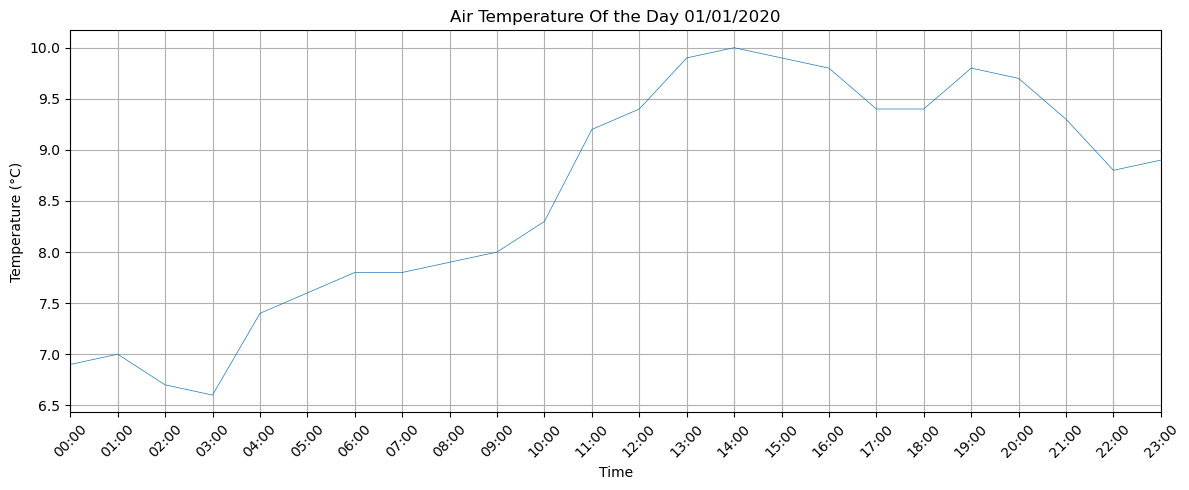

In [60]:
df_plot1 = (
    df.withColumn("dateTime", to_timestamp("dateTime", "dd-MMM-yyyy HH:mm"))
      .withColumn("air_temperature", col("air_temperature").cast("float"))
      .filter((col("air_temperature").isNotNull()) &
              (date_format("dateTime", "yyyy-MM-dd") == "2020-01-01"))
)

# df_plot1.show(n=df.count())
# writePath = "/home/jovyan/BigDataExercise/report1/plot1DF.csv"
# df_plot1.write.mode("overwrite").csv(writePath, header=True) 

df_plot1_panda = df_plot1.select("dateTime", "air_temperature").toPandas()

plt.figure(figsize=(12, 5))
plt.plot(df_plot1_panda["dateTime"], df_plot1_panda["air_temperature"], linewidth=0.5)
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xlim(datetime.datetime(2020, 1, 1, 0, 0), datetime.datetime(2020, 1, 1, 23, 0))
plt.title("Air Temperature Of the Day 01/01/2020")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()